In [42]:
import numpy as np
from scipy.special import logit
from scipy.stats import spearmanr
import networkx as nx
import random
import time
import pickle
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, precision_recall_curve, auc
import torch

In [70]:
import os
import pandas as pd
import csv
import numpy as np
import json
import multiprocessing
from itertools import repeat
import dateutil.parser as parser
import seaborn as sns # library for visualization
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
#import numpy as np
#from scipy.stats import rayleigh
import geopandas as gpd
from itertools import permutations

Some preprocessing

In [44]:
from math import radians, cos, sin, asin, sqrt

# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
def haversine(lon1, lat1, lon2, lat2):
  """
  Calculate the great circle distance between two points 
  on the earth (specified in decimal degrees)
  """
  # convert decimal degrees to radians 
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  # Radius of earth in kilometers is 6371
  km = 6371* c
  return km

In [45]:
#world_map_shapefilepath = os.path.join("ne_10m_admin_1_states_provinces", "naturalearth_adm1.shp")
#imd = gpd.read_file(world_map_shapefilepath, encoding = "utf-8")
#imd = imd.to_crs(4326)
#imd.fillna(value=np.nan, inplace=True)
#imd = final_imd.astype({column_name:'float'})
world_map_csv_filepath = os.path.join("ne_10m_admin_1_states_provinces", "naturalearth_adm1.csv")
df_map = pd.read_csv(world_map_csv_filepath, usecols=["gn_id", "name", "admin", "lon", "lat"], sep=";", keep_default_na=False)
df_map_nz = df_map[df_map["gn_id"] != -1]
id_list = df_map_nz["gn_id"].to_numpy().flatten()
print(id_list[:10])
N = len(id_list)
print("N:", N)
res = np.unique(id_list, return_counts=True)
freqs = res[1]
idx = np.where(freqs == 2)
print(res[0][idx])
id2geonameid = dict(zip(range(N), id_list))
geonameid2id = dict(zip(id_list, range(N)))
geonameid2name = dict(zip(id_list, df_map_nz["name"]))
geonameid2country = dict(zip(id_list, df_map_nz["admin"]))
geonameid2lon = dict(zip(id_list, df_map_nz["lon"]))
geonameid2lat = dict(zip(id_list, df_map_nz["lat"]))
#print(id2geoid)
#print("---")
#print(geoid2id)
#print(np.where(id_list==1844176))
#print(geonameid2id['1844176'])

[2960683 2960656 2960161 2960020 2959975 2960629 2960514 2960152 2960696
 2960599]
N: 3591
[]


In [326]:
##for index, row in df_map.iterrows():
#D = np.zeros((N,N))
#centroid_list = list(zip(df_map_nz["lon"], df_map_nz["lat"]))
#print(len(centroid_list))
#for i in range(N):
#    for j in range(N):
#        if i<j:
#            lon1 = centroid_list[i][0]
#            lat1 = centroid_list[i][1]
#            lon2 = centroid_list[j][0]
#            lat2 = centroid_list[j][1]
#            dist = haversine(lon1, lat1, lon2, lat2)
#            D[i,j] = dist
#            D[j,i] = dist

In [206]:
#D2 = np.trunc(1000 * D) / 1000
#pd.DataFrame(D2).to_csv("distance_matrix.csv", sep=";", quoting=csv.QUOTE_NONNUMERIC)

In [46]:
D = pd.read_csv("distance_matrix.csv", sep=";", keep_default_na=False, index_col=0, header=0).to_numpy()
np.fill_diagonal(D, 2)
print(D[:5,:5])

[[ 2.    24.168 30.974 18.514 15.895]
 [24.168  2.    18.958  7.751 17.873]
 [30.974 18.958  2.    24.457 15.561]
 [18.514  7.751 24.457  2.    17.884]
 [15.895 17.873 15.561 17.884  2.   ]]


Start

In [47]:
# Spreading parameters
gamma = 2  # <RW> recovery rate in the SIR process
epsilon_max = 0  # <RW> maximum layer mixing
ratio = 3  # <W> cascade-edge ratio
date_init = parser.parse("2018-12-31T00:00:00", dayfirst=False)
date_end = parser.parse("2022-01-01T00:00:00", dayfirst=False) # ending time
T_end = (date_end-date_init).total_seconds()//3600

#T2 = parser.parse("2019-01-01T00:00:00", dayfirst=False)
#print((T2-T_init).total_seconds()//3600)

In [48]:
# "Animal.type"
# day_no, week_no, biweek_no, month_no, year, season

df_events = pd.read_csv("geocoded_events_empresi.csv", usecols=["id", "hierarchy_data", "published_at", "disease", "month_no", "season", "year"], sep=";", keep_default_na=False)
# hierarchy_data: [798544, 858785, 7530742, 7532067, 772197] (the first element is for the country)
df_events["hierarchy_data"] = df_events["hierarchy_data"].apply(lambda x: eval(x))
df_events["published_at"] = df_events["published_at"].apply(lambda t: parser.parse(t, dayfirst=False))
df_events["timestamp"] = df_events["published_at"].apply(lambda t: (t-date_init).total_seconds()//3600) # in hours
df_events["year_effectif"] = df_events["year"]
idx = ((df_events["season"] == "winter") & (df_events["month_no"] == 12))
df_events.loc[idx, "year_effectif"] = df_events.loc[idx, "year"]+1
#print(df_events.loc[idx, "year_effectif"])
df_events = df_events[df_events["year_effectif"] != 2022]
#print(df_events[idx])
df_events["period"] = df_events["year_effectif"].apply(str)+"_"+df_events["season"]
#print(df_events["period"])

In [49]:
# we use geographic zones at ADM1 level, so if there is any entry which is only at country level, discard it
df_events["hier_level"] = df_events["hierarchy_data"].apply(lambda x: len(x))
df_events = df_events[df_events["hier_level"]>1]
df_events["geonameid"] = df_events["hierarchy_data"].apply(lambda x: x[1]) # get the id at ADM1 level

# sort data by date in ascendin order
df_events = df_events.sort_values(by='published_at', ascending=True)

Note that we do not perform any preprocessing to remove duplicated locations ids, because it is handled in the part "Construct data tensors from nonzero cascades". Remember the assumption in this method is that if a place is infected, it can be reinfected again later.

In [50]:
failed_geonameid_list = []
gn_id_list = df_events["geonameid"].to_numpy()
for gn_id in gn_id_list:
    if gn_id not in geonameid2id:
        failed_geonameid_list.append(gn_id)

print(len(failed_geonameid_list))
print(failed_geonameid_list[:10])

print("before", df_events.shape)
df_events["geoID"] = df_events["geonameid"].apply(lambda x: geonameid2id[x] if x in geonameid2id else -1) # get the id at ADM1 level
df_events = df_events[df_events["geoID"] != -1]
print("after", df_events.shape)

76
[12209922, 3313702, 2937477, 1844176, 1862037, 3419668, 3423548, 3423548, 6634611, 1849617]
before (4651, 12)
after (4575, 13)


In [51]:
splits = list(df_events.groupby("period"))
print(len(splits))
print(splits[0][0]) # group
print(splits[0][1]) # sub_dataframe

12
2019_autumn
        id                                     hierarchy_data published_at   
5723  5724  [1668284, 7280289, 9613373, 1677942, 11701969,...   2019-09-23  \
5711  5712                        [1668284, 7280291, 6655460]   2019-09-25   
5718  5719  [1668284, 7280291, 1679134, 1670693, 11700734,...   2019-09-25   
5934  5935                        [1835841, 1845788, 1922788]   2019-10-01   
5679  5680  [1668284, 7280291, 1679134, 1677075, 11703447,...   2019-10-12   
...    ...                                                ...          ...   
5782  5783                                 [3508796, 3505867]   2019-12-19   
5775  5776                                 [3508796, 3505867]   2019-12-19   
5763  5764  [3508796, 3499977, 3499980, 11154946, 11155571...   2019-12-19   
5761  5762  [3508796, 3499977, 3499980, 11154946, 11155571...   2019-12-19   
5786  5787  [3508796, 3499977, 3499980, 11154946, 11155571...   2019-12-19   

             disease  month_no  year  season  ti

In [53]:
C = len(splits)

data_nz = {} # nz: nonzero
#C_nz_idx = [] # TODO: no needed

# TODO: Recognize cascades of size above the cascades size threshold. In the original paper, it was 8.

for i in range(C):
    #C_nz_idx.append(i)
    df_sub = splits[i][1]
    data_nz[i] = list(zip(df_sub["timestamp"], df_sub["geoID"])) # (infection time, location id)

In [34]:
#write edgelist into file

inferred_src_gn_id_list = []
inferred_src_lon_list = []
inferred_src_lat_list = []
inferred_src_name_list = []
inferred_src_country_list = []
inferred_trgt_gn_id_list = []
inferred_trgt_lon_list = []
inferred_trgt_lat_list = []
inferred_trgt_name_list = []
inferred_trgt_country_list = []
inferred_w_a_list = []
inferred_w_b_list = []
for new_idx, old_idx in enumerate(succ_edges_list):
    i = old_idx // N
    j = old_idx % N
    if A[new_idx]>=threshold: # << threshold is determined by the previous step
        src_gn_id = id2geonameid[i]
        trgt_gn_id = id2geonameid[j]
        inferred_src_gn_id_list.append(src_gn_id)
        inferred_src_lon_list.append(geonameid2lon[src_gn_id])
        inferred_src_lat_list.append(geonameid2lat[src_gn_id])
        inferred_src_name_list.append(geonameid2name[src_gn_id])
        inferred_src_country_list.append(geonameid2country[src_gn_id])
        inferred_trgt_gn_id_list.append(trgt_gn_id)
        inferred_trgt_lon_list.append(geonameid2lon[trgt_gn_id])
        inferred_trgt_lat_list.append(geonameid2lat[trgt_gn_id])
        inferred_trgt_name_list.append(geonameid2name[trgt_gn_id])
        inferred_trgt_country_list.append(geonameid2country[trgt_gn_id])
        inferred_w_a_list.append(A[new_idx])
        inferred_w_b_list.append(B[new_idx])
df_inferred_edgelist = pd.DataFrame({
    "source_geonameId":inferred_src_gn_id_list,
    "source_lon":inferred_src_lon_list,
    "source_lat":inferred_src_lat_list,
    "source_geonameId":inferred_src_gn_id_list,
    "source_name":inferred_src_name_list,
    "source_country":inferred_src_country_list,
    "target_geonameId":inferred_trgt_gn_id_list,
    "target_lon":inferred_trgt_lon_list,
    "target_lat":inferred_trgt_lat_list,
    "target_name":inferred_trgt_name_list,
    "target_country":inferred_trgt_country_list,
    "weight_alpha": inferred_w_a_list,
    "weight_beta": inferred_w_b_list
})
print(df_inferred_edgelist)
df_inferred_edgelist.to_csv("inferred_edgelist.csv", sep=";", quoting=csv.QUOTE_NONNUMERIC, index=False)

      source_geonameId  source_lon  source_lat     source_name source_country   
0               592075   27.327484   59.177733        Ida-Viru        Estonia  \
1              1568769  108.678455   15.020550      Quảng Ngãi        Vietnam   
2              2125072  163.004509   58.930146       Kamchatka         Russia   
3               592075   27.327484   59.177733        Ida-Viru        Estonia   
4              2761367   16.384135   48.223186            Wien        Austria   
...                ...         ...         ...             ...            ...   
3945           2822542   11.023867   50.896648       Thüringen        Germany   
3946           6418542    9.444080   55.354644      Syddanmark        Denmark   
3947           6201374   59.605661   32.357063  South Khorasan           Iran   
3948           3141558    6.222784   59.112690        Rogaland         Norway   
3949           6418542    9.444080   55.354644      Syddanmark        Denmark   

      target_geonameId  tar

In [12]:
# Construct data tensors from nonzero cascades

time_dict = {e:0.0 for e in range(N * N)} # transmission edge'lere index atiyo hash yontemiyle, o yuzden init yaparak N*N yapiyo 
mask_dict = {c:set() for c in range(C)}

succ_edges = set()
#nejat = []
for c in range(C):
	if c % 5 == 0 and c != 0:
		print('Finished parsing %d cascades' % c)

	sim_logs = data_nz[c]

	succ_users = []
	fail_users = set(range(N))

	for (t, j) in sim_logs: # for each cascade c, it returns a list of tuples (t,j) stating that node j is infected at time t.
		if t > T_end:
			break
        # Insteading of adding all edge pairs, the authors notice that it is unlikely for an edge to exist
        # between two nodes that never occur in the same cascade.
        # Therefore, in the single layer phase, we only consider the
        # set of “possible” edges – i.e., edges between nodes that co-occur
        # in at least one cascade 
		if j in fail_users: # it ensures that we do not add the same location id twice
			for (u, t_u) in succ_users: # the previously infected locations (succ_users) might infect the location j
				if u != j:
					idx = u * N + j # index of the directed edge (u, j)
					#nejat.append((u, j, idx))
					mask_dict[c].add(idx)
					succ_edges.add(idx)
					time_dict[idx] += t - t_u
				else:
					break
			succ_users.insert(0, (j, t)) # node j is activated at time t on cascade c
			fail_users.remove(j)

	for (j, t_j) in succ_users: # for each activated node j on cascade c
        # TODO: I dont understand why we update the activation time of the fail_users .. ?
		for n in fail_users:
			idx = j * N + n
			time_dict[idx] += T_end - t_j # TODO: check if these values are used later in the code !!
            
#print(nejat[0:20])
succ_edges_list = list(succ_edges)
succ_edges_dict = {k: v for v, k in enumerate(succ_edges_list)} # {'a': 0, 'c': 1}
n_succ_edges = len(succ_edges_list)
#print(succ_edges_dict)
#print(succ_edges_dict) # {8194: 0, 3: 1, 8196: 2, 5: 3, 8198: 4, 6 ... }

Finished parsing 5 cascades
Finished parsing 10 cascades


In [14]:
dist_list_for_succ_edges = []
n_poss_edges = N*(N-1)
print(n_succ_edges,"/",n_poss_edges,"=",n_succ_edges/n_poss_edges)

# prepare dist list for succ edges
for i in range(n_succ_edges):
    e_idx = succ_edges_list[i]
    #e_idx hash value gibi calculate edildigi icin, o hash value'dan node index'leri geri buluyo
    i = e_idx // N
    j = e_idx % N
    dist = D[i,j]
    dist_list_for_succ_edges.append(dist)
    
#print(dist_for_succ_edges[:10])
print(len(dist_list_for_succ_edges))

56184 / 12891690 = 0.004358156300686721
56184


In [15]:
print(len(time_dict))
print(succ_edges_list[0:20])
print(mask_dict[0])
print(n_succ_edges)

12895281
[4980736, 6946817, 4980737, 1310722, 4980740, 2621443, 1179654, 4980743, 10616840, 12845064, 11534346, 4980746, 11534348, 2621453, 11403278, 4980750, 2621456, 6955774, 4980754, 4980749]
{773640, 4188681, 6731276, 5657612, 6729749, 772117, 4187158, 12888098, 6732324, 6732325, 6255653, 6732327, 7573550, 6729775, 7574581, 7574585, 6731321, 10733630, 12886083, 10734661, 10734665, 4172873, 12884560, 12893265, 12886617, 12891742, 772196, 4187237, 12893799, 188519, 4188268, 10020465, 10024056, 7575161, 10018942, 7573634, 10022533, 10031238, 10735241, 7576209, 7576210, 10733714, 7576212, 4174484, 6255763, 10029715, 7573660, 4172957, 6257309, 12884639, 10736290, 10736292, 12885670, 7575206, 12885674, 10733740, 12891821, 773807, 4188848, 12892852, 10735286, 4172983, 12892856, 4187321, 867006, 4174529, 865483, 10019021, 772306, 4187347, 10020052, 10022612, 10020056, 10023643, 773852, 4188893, 10023647, 10029794, 10030825, 12886250, 6732523, 10030829, 12884723, 12893432, 12891905, 1288729

In [16]:
i = 0
for k in time_dict:
    print(time_dict[k])
    i+=1
    if i>10:
        break
        
i = 0
for k in mask_dict:
    print(mask_dict[k])
    i+=1
    if i>10:
        break
        
print(C)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
{773640, 4188681, 6731276, 5657612, 6729749, 772117, 4187158, 12888098, 6732324, 6732325, 6255653, 6732327, 7573550, 6729775, 7574581, 7574585, 6731321, 10733630, 12886083, 10734661, 10734665, 4172873, 12884560, 12893265, 12886617, 12891742, 772196, 4187237, 12893799, 188519, 4188268, 10020465, 10024056, 7575161, 10018942, 7573634, 10022533, 10031238, 10735241, 7576209, 7576210, 10733714, 7576212, 4174484, 6255763, 10029715, 7573660, 4172957, 6257309, 12884639, 10736290, 10736292, 12885670, 7575206, 12885674, 10733740, 12891821, 773807, 4188848, 12892852, 10735286, 4172983, 12892856, 4187321, 867006, 4174529, 865483, 10019021, 772306, 4187347, 10020052, 10022612, 10020056, 10023643, 773852, 4188893, 10023647, 10029794, 10030825, 12886250, 6732523, 10030829, 12884723, 12893432, 12891905, 12887298, 12887299, 12887301, 12884749, 12894480, 12894481, 12894483, 12886295, 10020632, 865562, 12891931, 10024223, 10019105, 12893477, 10022696, 10031405, 

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
overall_start_time = time.time()

# Construct time tensor
time_val = np.array(list(time_dict.values()))[succ_edges_list] # keep only successful activation times
delta_t = torch.FloatTensor(time_val).to(device)

# Construct dist tensor
dist_val = np.array(dist_list_for_succ_edges) # only successful activation times
delta_dist = torch.FloatTensor(dist_val).to(device)

# Construct mask and scatter tensor
mask_idx = []
scatter_idx = []
succ_cnt = 0
for c in range(C):
	mask_idx_list = []
	scatter_idx_list = []
	succ_cnt += len(mask_dict[c])
	for old_idx in mask_dict[c]: # succ edges on cascade c
        # old_index hash value gibi calculate edildigi icin, o hash value'dan node index'leri geri buluyo
		i = old_idx // N
		j = old_idx % N
		new_index = j * C + c   # bu index'te node i'nin onemi yok, cunku activated olan node j
                                # node j, sadece bir tane cascade'de de bulunabilir, ya da hepsinde 
		scatter_idx_list.append(new_index)
        # succ_edges_dict = {8194: 0, 3: 1, 8196: 2, 5: 3, 8198: 4, 6 ... }
		mask_idx_list.append(succ_edges_dict[old_idx])
	mask_idx.append(torch.LongTensor(mask_idx_list).to(device))
	scatter_idx.append(torch.LongTensor(scatter_idx_list).to(device))

print('Finished data parsing and tensor construction\n\nStarting optimization')
print(len(scatter_idx))
#print(mask_idx)

Finished data parsing and tensor construction

Starting optimization
12


In [18]:
# Optimization parameters
max_iter = 500  # <W> maximum number of optimization iterations
min_iter = 100  # minimum number of optimization iterations
learning_rate = 0.5  # initial learning rate of the Adam optimizer
tol = 0.0001  # threshold of relative objective value change for stopping the optimization


In [20]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


In [24]:
# Conduct Inference
# Define objective function
def objective(params):
	alpha_p = torch.sigmoid(params[:n_succ_edges])
	beta_p = torch.sigmoid(params[(n_succ_edges):(2*n_succ_edges)])
	eps_p = torch.sigmoid(params[(2*n_succ_edges):(2*n_succ_edges+N)])
    
	alpha_p_delta_t_beta_p = alpha_p * delta_t * beta_p

	H0 = eps_p
    
	H = torch.zeros(N * C, device=device) # hazard func
	for c in range(C):
        # mask_idx[c]: index of succ edges on cascade c
		#H.scatter_add_(dim=0, index=scatter_idx[c], src=alpha_p.index_select(0, mask_idx[c])) # dim 0: line-wise
        # TODO: perform the log operation before doing the summation
		H.scatter_add_(dim=0, index=scatter_idx[c], src=alpha_p_delta_t_beta_p.index_select(0, mask_idx[c])) # dim 0: line-wise

	H_nonzero = H[H != 0]
    
	S0 = eps_p
    
	S = 0.5 * (delta_t**2) * alpha_p * delta_dist * beta_p # survival func

	return torch.sum(S0) + torch.sum(S) - torch.sum(torch.log(H_nonzero)) - torch.sum(torch.log(H0))

In [25]:
# Initialize parameters: we put all parameters into the same array to optimize them togethr in the Adam opt.
params_init = np.random.uniform(-5, 5, 2*n_succ_edges+N) # sigmoid'e koycagi icin boyle init yapiyo
                                                    # sigmoid(-5) = 0.0067, sigmoid(5) = 0.9933
params_g = torch.tensor(params_init, requires_grad=True, device=device, dtype=torch.float)

#beta_init = np.random.uniform(-5, 5, n_succ_edges)
#params_b = torch.tensor(beta_init, requires_grad=True, device=device, dtype=torch.float)

#epsilon_init = np.random.uniform(-5, 5, N)
#params_e = torch.tensor(epsilon_init, requires_grad=True, device=device, dtype=torch.float)

# Initialize optimizer
opt = torch.optim.Adam([params_g], lr=learning_rate)

In [26]:
infer_time = 0
eval_time = 0

lik_list = []

# Conduct optimization
for it in range(max_iter):
	# Calculate objective
	start_time = time.time()
    # ==========================
	loss = objective(params_g)
    # ==========================
	loss_val = loss.item()
	lik_list.append(loss_val)
	end_time = time.time()
	infer_time += end_time - start_time

	print('Iteration %d loss: %.4f' % (it + 1, loss_val))

#	# Evaluate accuracy
#	start_time = time.time()
#	alpha_inferred_nonzero = torch.sigmoid(params_g[:n_succ_edges]).cpu().detach().numpy()
#	alpha_inferred = np.zeros((N, N))# like an adjacency matrix
#	for new_idx, old_idx in enumerate(succ_edges_list):
#		i = old_idx // N
#		j = old_idx % N
#		alpha_inferred[i, j] = alpha_inferred_nonzero[new_idx]
#	alpha_pred = alpha_inferred.flatten()
#	beta_inferred_nonzero = torch.sigmoid(params_g[(n_succ_edges):(2*n_succ_edges)]).cpu().detach().numpy()
#	beta_inferred = np.zeros((N, N))# like an adjacency matrix
#	for new_idx, old_idx in enumerate(succ_edges_list):
#		i = old_idx // N
#		j = old_idx % N
#		beta_inferred[i, j] = beta_inferred_nonzero[new_idx]
#	beta_pred = beta_inferred.flatten()
#	eps_inferred_nonzero = torch.sigmoid(params_g[(2*n_succ_edges):(2*n_succ_edges+N)]).cpu().detach().numpy()
#	end_time = time.time()
#	eval_time += end_time - start_time

	# Stop optimization when relative decrease in objective value lower than threshold
	if it > min_iter and len(lik_list) >= 2 and (lik_list[-2] - lik_list[-1]) / lik_list[-2] < tol:
		break

	# Loss propagation
	start_time = time.time()
	opt.zero_grad()
	loss.backward()
	opt.step()
	end_time = time.time()
	infer_time += end_time - start_time

print('\nOptimization time for N=%d, C=%d, gamma=%d, epsilon_max=%.1f' % (N, C, gamma, epsilon_max))
if torch.cuda.is_available():
	print('Max cuda memory allocated: %.4f' % torch.torch.cuda.max_memory_allocated())

alpha_inferred_nonzero = torch.sigmoid(params_g[:n_succ_edges]).cpu().detach().numpy()
beta_inferred_nonzero = torch.sigmoid(params_g[(n_succ_edges):(2*n_succ_edges)]).cpu().detach().numpy()
eps_inferred_nonzero = torch.sigmoid(params_g[(2*n_succ_edges):(2*n_succ_edges+N)]).cpu().detach().numpy()

# Save results to file
res_dict = {}
res_dict['succ_edges_list'] = succ_edges_list
res_dict['alpha_inferred_nonzero'] = alpha_inferred_nonzero
res_dict['beta_inferred_nonzero'] = beta_inferred_nonzero
res_dict['eps_inferred_nonzero'] = eps_inferred_nonzero
res_dict['lik'] = lik_list
#res_dict['time'] = {'parse': parse_time, 'tensor': tensor_time, 'infer': infer_time, 'eval': eval_time}
if torch.cuda.is_available():
	res_dict['memory'] = torch.torch.cuda.max_memory_allocated()

Iteration 1 loss: 28100261620744192.0000
Iteration 2 loss: 22979612631891968.0000
Iteration 3 loss: 18406479631482880.0000
Iteration 4 loss: 14375416600985600.0000
Iteration 5 loss: 10885186589818880.0000
Iteration 6 loss: 7937136070230016.0000
Iteration 7 loss: 5529444512956416.0000
Iteration 8 loss: 3649453038764032.0000
Iteration 9 loss: 2264081809539072.0000
Iteration 10 loss: 1313496562139136.0000
Iteration 11 loss: 713665187676160.0000
Iteration 12 loss: 368177884168192.0000
Iteration 13 loss: 185431790452736.0000
Iteration 14 loss: 94326675734528.0000
Iteration 15 loss: 49837135364096.0000
Iteration 16 loss: 27789199671296.0000
Iteration 17 loss: 16443471036416.0000
Iteration 18 loss: 10315093770240.0000
Iteration 19 loss: 6830818328576.0000
Iteration 20 loss: 4748998606848.0000
Iteration 21 loss: 3446553968640.0000
Iteration 22 loss: 2597067161600.0000
Iteration 23 loss: 2022037389312.0000
Iteration 24 loss: 1619768115200.0000
Iteration 25 loss: 1330064654336.0000
Iteration 26 

In [27]:
print(np.max(res_dict['alpha_inferred_nonzero']))
print(np.max(res_dict['beta_inferred_nonzero']))
print(np.max(res_dict['eps_inferred_nonzero']))

0.9931352
0.9931584
0.9999479


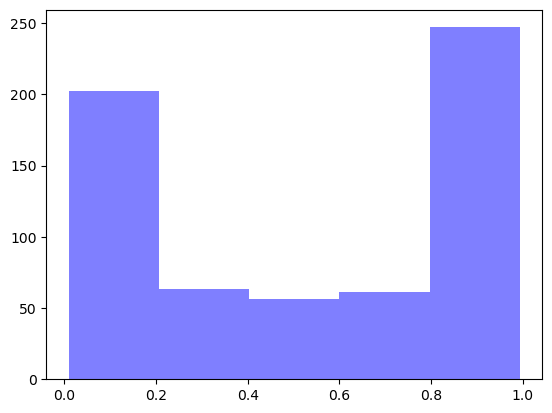

In [40]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

A = np.array(res_dict['alpha_inferred_nonzero'])
A[A<0.01] = None
#print(x[x>0.8])
#print(len(x[x>0.8]))
num_bins = 5
n, bins, patches = plt.hist(A, num_bins, facecolor='blue', alpha=0.5)

#plt.yscale('log')
plt.show()

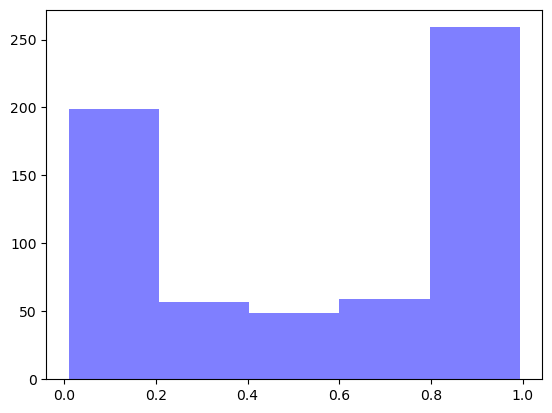

In [39]:
B = np.array(res_dict['beta_inferred_nonzero'])
B[B<0.01] = None
#print(x[x>0.8])
#print(len(x[x>0.8]))
num_bins = 5
n, bins, patches = plt.hist(B, num_bins, facecolor='blue', alpha=0.5)

#plt.yscale('log')
plt.show()

In [31]:
# write raw results into pickle file
res_filename = 'raw_results_s_%d_%d_%d_%d.pkl' % (N, len(succ_edges_list), C, max_iter)
with open(res_filename, 'wb') as fp:
	pickle.dump(res_dict, fp)

In [32]:
# Rank the edges by inferred edge weight in the single layer phase
E_ratio = 1.1
E_infer = int(E_ratio * N) # we expect slightly more than nb nodes
alpha_inferred_sorted = np.partition(alpha_inferred_nonzero, len(alpha_inferred_nonzero) - E_infer)
threshold = alpha_inferred_sorted[len(alpha_inferred_nonzero) - E_infer]
print("threshold:",threshold)
# edge weight threshold above which there are <E_infer> edges

threshold: 0.0034182097


## Multilayer phase

In [54]:
## Read single layer inference results
#res_filename = 'results/s_%d_%d_%d_%d_%.1f_%.1f_%.2f_%d.pkl' % (N, E, C_base, K, gamma, epsilon_max, overlap, s_max_iter)
#with open(res_filename, 'rb') as fp:
#    res_dict = pickle.load(fp)
#succ_edges_list = res_dict['succ_edges_list']
#alpha_inferred_nonzero = res_dict['alpha_inferred_nonzero']

K = 2 # nb layers
print(K)

2


Remember this data:

In [61]:
C = len(splits)

data_nz = {} # nz: nonzero
#C_nz_idx = [] # TODO: no needed

# TODO: Recognize cascades of size above the cascades size threshold. In the original paper, it was 8.

for i in range(C):
    #C_nz_idx.append(i)
    df_sub = splits[i][1]
    data_nz[i] = list(zip(df_sub["timestamp"], df_sub["geoID"])) # (infection time, location id)

In [62]:
# Read single layer inference results
df_edgelist = pd.read_csv("inferred_edgelist.csv", sep=";", keep_default_na=False)
# source_geonameId, target_geonameId
E_infer = df_edgelist.shape[0]
print(E_infer)

3950


In [63]:
# distance between Japan and Germany
print(D[geonameid2id[1859133],geonameid2id[2822542]])
# distance between Japan and Vietnam
print(D[geonameid2id[1859133],geonameid2id[1576632]])
# distance between Netherlands and Germany
print(D[geonameid2id[3319179],geonameid2id[2822542]])

9075.937
2919.733
421.252


In [64]:
# construct graph from edgelist
graph=nx.DiGraph()

# create nodes
for index, row in df_edgelist.iterrows():
    src_geonameId = row["source_geonameId"]
    trgt_geonameId = row["target_geonameId"]
    weight = row["weight_alpha"]

    if not graph.has_node(src_geonameId):
        graph.add_node(src_geonameId)
    if not graph.has_node(trgt_geonameId):
        graph.add_node(trgt_geonameId)

    if not graph.has_edge(src_geonameId, trgt_geonameId):
        graph.add_edge(src_geonameId, trgt_geonameId, weight=weight, index=index)
    
print(graph[1859133][1852553])
print(graph.has_edge(1859133, 1852552))
#print(graph.edges(data=True))

{'weight': 0.0715188607573509, 'index': 38}
False


In [65]:
# Construct data tensors from cascades

# C: nb cascades
print(C)

mask_dict = {e: 0 for e in range(E_infer * C)} # either 0 or 1
time_dict = {e: 0 for e in range(E_infer * C)}
dist_dict = {e: 0 for e in range(E_infer * C)} # TODO: init with 0 is correct ?

#succ_edges_by_cascade = {}

scatter_index_list = []

#start_time = time.time()
for c in range(C):
    #succ_edges_by_cascade[c] = []
    
    if c % 5 == 0 and c != 0:
        print('Finished parsing %d cascades' % c)
    sim_logs = data_nz[c]

    for e in graph.edges(data=True): # it is normal to repeat this loop for each cascade
        geonameid_j = e[1]
        j = geonameid2id[geonameid_j] # node idx
        scatter_index_list.append(j * C + c)

    succ_users = set()
    fail_users = set(range(N))

    for (t, j) in sim_logs: # for each cascade c, it returns a list of tuples (t,j) stating that node j is infected at time t.
        geonameid_j = id2geonameid[j]
        if j in fail_users:
            if t > T_end:
                break
            for (u, t_u) in succ_users:
                geonameid_u = id2geonameid[u]
                #e = N * u + j
                #print(u,"->",j)
                if graph.has_edge(geonameid_u,geonameid_j): # according to the result of the single layer phase
                    #print("has edge")
                    idx = c * E_infer + graph[geonameid_u][geonameid_j]["index"]
                    mask_dict[idx] = 1
                    time_dict[idx] += t - t_u
                    dist_dict[idx] = D[u,j]
                    #succ_edges_by_cascade[c].append("("+str(t)+","+str(u)+","+str(j)+")")
            succ_users.add((j, t))
            fail_users.remove(j)
            
    for (j, t_j) in succ_users:
        for n in fail_users:
            #e = N * j + n
            if graph.has_edge(geonameid_u, geonameid_j):
                idx = c * E_infer + graph[geonameid_u][geonameid_j]["index"]
                time_dict[idx] += T - t_j

end_time = time.time()
parse_time = end_time - start_time

start_time = time.time()
mask = torch.tensor(list(mask_dict.values()), dtype=torch.uint8).view(C, E_infer).to(device)
delta_t = torch.tensor(list(time_dict.values())).view(C, E_infer).to(device)
delta_dist = torch.tensor(list(dist_dict.values())).view(C, E_infer).to(device)
scatter_index = torch.tensor(scatter_index_list, dtype=torch.int64).to(device)
end_time = time.time()
tensor_time = end_time - start_time

print('Finished data parsing and tensor construction')


#df = pd.DataFrame.from_dict(succ_edges_by_cascade, orient='index')
#print(df.shape)
#print(df)
#succ_edges_by_cascade_filepath = 'logs/succ_edges_by_cascade_%d_%d_%d_%d_%.1f_%d_%.1f_%.2f_%d_%d.csv' % (N, E, K, C_base, gamma, s_c, epsilon_max, overlap, seed, s_max_iter)
#df.to_csv(succ_edges_by_cascade_filepath, sep=";", quoting=csv.QUOTE_NONNUMERIC)

12
Finished parsing 5 cascades
Finished parsing 10 cascades
Finished data parsing and tensor construction


In [66]:
t1 = torch.tensor([1,2,3,4])
t2 = torch.tensor([5,6,7,8])
t3 = torch.tensor([9,10,11,12])

ll = []
ll.append(t1)
ll.append(t2)
ll.append(t3)

print(torch.stack(ll,dim=0))
print(torch.stack(ll,dim=1))
print(torch.stack(ll,dim=-1))

print(torch.flatten(torch.stack(ll,dim=-1)))

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])
tensor([[ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11],
        [ 4,  8, 12]])
tensor([[ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11],
        [ 4,  8, 12]])
tensor([ 1,  5,  9,  2,  6, 10,  3,  7, 11,  4,  8, 12])


In [77]:
#Conduct Inference
# Define objective function
def objective(params):
    alpha_p = torch.sigmoid(params[:(E_infer * K)]).view(K, E_infer) # >> K x E_infer
    beta_p = torch.sigmoid(params[(E_infer * K):(2 * E_infer * K)]).view(K, E_infer) # >> K x E_infer
    eps_p = torch.sigmoid(params[(2 * E_infer * K):(2 * E_infer * K + N)]).view(N) # >> 1 x N
    alpha_beta_p = alpha_p * beta_p
    
    pi_list = []
    for k in range(K - 1):
        pi_rm = 1
        for i in range(k):
            pi_rm -= pi_list[i]
        pi_list.append(torch.sigmoid(params[(2 * E_infer * K + N + C * k):(2 * E_infer * K + N + C * (k + 1))]) * pi_rm)
    pi_rm = 1
    for pi in pi_list:
        pi_rm -= pi
    pi_list.append(pi_rm) # for the last layer, i.e. layer K
    pi_p = torch.stack(pi_list, dim=-1).to(device) # -1 indicates the last dimension >> C x K

    alpha_beta_pi_prod = torch.matmul(pi_p, alpha_beta_p) # >> C x E_infer

    # hazard func
    H0 = eps_p
    
    H = torch.zeros(N * C, dtype=torch.double).to(device).scatter_add_(0, scatter_index, torch.flatten(mask * delta_t * alpha_beta_pi_prod))
    H_nonzero = H[H != 0]
    
    # survival func
    S0 = eps_p

    #S = delta_t * alpha_pi_prod # survival func
    S = 0.5 * (delta_t**2) * alpha_beta_pi_prod * delta_dist # survival func
    
    return torch.sum(S0) + torch.sum(S) - torch.sum(torch.log(H_nonzero)) - torch.sum(torch.log(H0))

In [78]:
print('Starting optimization')

# Initialize parameters: we put all parameters into the same array to optimize them togethr in the Adam opt.

params_init = np.random.uniform(-5, 5, size=(2 * E_infer * K + N + C * (K - 1)))
params_g = torch.tensor(params_init, requires_grad=True, device=device)

#alpha_init = np.random.uniform(-5, 5, E_infer * K)
#params_alpha = torch.tensor(alpha_init, requires_grad=True, device=device, dtype=torch.float)
#
#pi_init = np.random.uniform(-5, 5, size=(C * (K - 1)))
#params_p = torch.tensor(pi_init, requires_grad=True, device=device)
#
#beta_init = np.random.uniform(-5, 5, E_infer * K)
#params_b = torch.tensor(beta_init, requires_grad=True, device=device, dtype=torch.float)
#
#epsilon_init = np.random.uniform(-5, 5, N)
#params_e = torch.tensor(epsilon_init, requires_grad=True, device=device, dtype=torch.float)

# Initialize optimizer
opt = torch.optim.Adam([params_g], lr=learning_rate)

infer_time = 0
eval_time = 0

lik_list = [] # loss value list
pi_acc_list = []
orders = list(permutations(range(K))) # layer orders
print("orders", orders)

Starting optimization
orders [(0, 1), (1, 0)]


In [79]:
# Conduct optimization
for it in range(max_iter):
    # Calculate objective
    start_time = time.time()
    loss = objective(params_g)
    loss_val = loss.item()
    lik_list.append(loss_val)
    end_time = time.time()
    infer_time += end_time - start_time

    print('Iteration %d loss: %.4f' % (it + 1, loss_val))

    # Parse inferred pi values
#    start_time = time.time()
#    alpha_inferred = torch.sigmoid(params_g[:(E_infer * K)]).view(K, E_infer).cpu().detach().numpy().T
#    beta_inferred = torch.sigmoid(params_g[(E_infer * K):(2 * E_infer * K)]).view(K, E_infer).cpu().detach().numpy().T
#    eps_inferred = torch.sigmoid(params_g[(2 * E_infer * K):(2 * E_infer * K + N)]).view(N).cpu().detach().numpy().T
#    pi_list = []
#    for k in range(K - 1):
#        pi_rm = 1
#        for i in range(k):
#            pi_rm -= pi_list[i]
#        pi_list.append(torch.sigmoid(params_g[(E_infer * K + C * k):(E_infer * K + C * (k + 1))]).cpu().detach() * pi_rm)
#    pi_rm = 1
#    for pi in pi_list:
#        pi_rm -= pi
#    pi_list.append(pi_rm)
#    pi_inferred = torch.stack(pi_list, dim=-1)

#    # Evaluate pi accuracy
#    acc_pi_best = 0
#    for order in orders:  # enumerate possible orders of layers
#        acc_pi = accuracy_score(np.argmax(pi_inferred[:, order], axis=1), np.argmax(pi_nz, axis=1))
#        if acc_pi > acc_pi_best:
#            acc_pi_best = acc_pi
#    print('Pi accuracy: %.4f' % acc_pi_best)
#    pi_acc_list.append(acc_pi_best)
#    end_time = time.time()
#    eval_time += end_time - start_time

    # Stop optimization when relative decrease in objective value lower than threshold
    if it > min_iter and len(lik_list) >= 2 and (lik_list[-2] - lik_list[-1]) / lik_list[-2] < tol:
        break

    # Loss propagation
    start_time = time.time()
    opt.zero_grad()
    loss.backward()
    opt.step()
    end_time = time.time()
    infer_time += end_time - start_time

Iteration 1 loss: 1741579505219.2131
Iteration 2 loss: 1399998113907.8601
Iteration 3 loss: 1107612238723.5308
Iteration 4 loss: 858805821224.1135
Iteration 5 loss: 648130015510.9825
Iteration 6 loss: 472091759612.5007
Iteration 7 loss: 329114251312.3584
Iteration 8 loss: 217910294779.7580
Iteration 9 loss: 135935681791.9294
Iteration 10 loss: 79391568555.5974
Iteration 11 loss: 43425321299.4635
Iteration 12 loss: 22506258348.3009
Iteration 13 loss: 11329020803.9293
Iteration 14 loss: 5719879685.6957
Iteration 15 loss: 2981465470.8556
Iteration 16 loss: 1634329914.7559
Iteration 17 loss: 949600822.4373
Iteration 18 loss: 585198740.7550
Iteration 19 loss: 381220471.2040
Iteration 20 loss: 261184276.6348
Iteration 21 loss: 187147624.1482
Iteration 22 loss: 139482038.4589
Iteration 23 loss: 107589936.2046
Iteration 24 loss: 85508329.7033
Iteration 25 loss: 69749241.5192
Iteration 26 loss: 58197848.7321
Iteration 27 loss: 49528977.8135
Iteration 28 loss: 42886926.2034
Iteration 29 loss: 37

In [82]:
# Parse inferred pi values
alpha_inferred = torch.sigmoid(params_g[:(E_infer * K)]).view(K, E_infer).cpu().detach().numpy().T
beta_inferred = torch.sigmoid(params_g[(E_infer * K):(2 * E_infer * K)]).view(K, E_infer).cpu().detach().numpy().T
eps_inferred = torch.sigmoid(params_g[(2 * E_infer * K):(2 * E_infer * K + N)]).view(N).cpu().detach().numpy().T
pi_list = []
for k in range(K - 1):
    pi_rm = 1
    for i in range(k):
        pi_rm -= pi_list[i]
    pi_list.append(torch.sigmoid(params_g[(E_infer * K + C * k):(E_infer * K + C * (k + 1))]).cpu().detach() * pi_rm)
pi_rm = 1
for pi in pi_list:
    pi_rm -= pi
pi_list.append(pi_rm)
pi_inferred = torch.stack(pi_list, dim=-1)

#    # Evaluate pi accuracy
#    acc_pi_best = 0
#    for order in orders:  # enumerate possible orders of layers
#        acc_pi = accuracy_score(np.argmax(pi_inferred[:, order], axis=1), np.argmax(pi_nz, axis=1))
#        if acc_pi > acc_pi_best:
#            acc_pi_best = acc_pi
#    print('Pi accuracy: %.4f' % acc_pi_best)
#    pi_acc_list.append(acc_pi_best)
#    end_time = time.time()
#    eval_time += end_time - start_time

In [87]:
# hangi cascade'in hangi layer'de oldugunu gosteriyo
print(np.around(pi_inferred.numpy(), decimals=3))
print(pi_inferred.shape)

# when dim=0, get maximum index along columns with argmax
# when dim=1, get maximum index along rows with argmax
print(torch.argmax(pi_inferred, dim=0).numpy())
print(torch.argmax(pi_inferred, dim=1).numpy())

df = pd.DataFrame(np.around(pi_inferred.numpy(), decimals=3), columns = ['layer'+str(k) for k in range(K)])
print(df.shape)

res_filename = 'results_multilayer_cascade_membership_m_%d_%d_%d_%d_%d.csv' % (N, E_infer, K, C, max_iter) # seed, s_max_iter
df.to_csv(res_filename, sep=";", quoting=csv.QUOTE_NONNUMERIC)

[[0.003 0.997]
 [0.002 0.998]
 [0.001 0.999]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.001 0.999]
 [0.003 0.997]
 [0.001 0.999]
 [0.003 0.997]
 [0.    1.   ]
 [0.001 0.999]]
torch.Size([12, 2])
[ 9 10]
[1 1 1 1 1 1 1 1 1 1 1 1]
(12, 2)


In [ ]:
# Prepare for multilayer edge list
# for each layer, recognize cascades that spread on it and remove edges that are not activated by these cascades
start_time = time.time()
pi_b = torch.argmax(pi_inferred, dim=1).numpy()

c_cluster = {k:set() for k in range(K)}
for c in range(C): # cascade'lari K cluster'a ayiriyo
    c_cluster[pi_b[c]].add(c)

nz_edges_l = {k:set() for k in range(K)} # non zero edges by layer
for k in range(K):
    for c in c_cluster[k]:
        sim_logs = data_nz[c]
        sim_logs.sort() # TODO

        succ_users = set()
        fail_users = set(range(N))

        for (t, j) in sim_logs:
            if j in fail_users:
                geonameid_j = id2geonameid[j]
                if t > T_end:
                    break
                for (u, t_u) in succ_users:
                    geonameid_u = id2geonameid[u]
                    e_idx = N * u + j
                    #e_idx = c * E_infer + graph[geonameid_u][geonameid_j]["index"]
                    if graph.has_edge(geonameid_u,geonameid_j):
                        nz_edges_l[k].add(e_idx)
                succ_users.add((j, t))
                fail_users.remove(j)

alpha_inferred_nonzero = torch.sigmoid(params_g[:(E_infer * K)]).view(K, E_infer).cpu().detach().numpy().T
alpha_inferred = np.zeros((N, N, K))
source_list = []
target_list = []
layer_list = []
weight_list = []
for k in range(K):
    for e_idx in nz_edges_l[k]:
        i = e_idx // N
        j = e_idx % N
        w = alpha_inferred_nonzero[nonzero_edges[e_idx], k] # TODO
        alpha_inferred[i, j, k] = w
        source_list.append(i)
        target_list.append(j)
        layer_list.append(k)
        weight_list.append(w)

data = {'source': source_list, 'target': target_list, 'layer': layer_list, 'weight': weight_list}
df = pd.DataFrame.from_dict(data)
print(df.shape)
final_edges_filepath = 'results/final_edges_%d_%d_%d_%d_%.1f_%d_%.1f_%.2f_%d_%d.csv' % (N, E, K, C_base, gamma, s_c, epsilon_max, overlap, seed, s_max_iter)
#df.to_csv(final_edges_filepath, sep=";", quoting=csv.QUOTE_NONNUMERIC)